# Importing the libraries

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
from torchvision import datasets, transforms

# RBM Architecture

In [13]:
class RBM(nn.Module):
    def __init__(self, nv, nh):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(nh, nv) * 0.1)  # Weight matrix
        self.a = nn.Parameter(torch.zeros(1, nh))  # Hidden biases
        self.b = nn.Parameter(torch.zeros(1, nv))  # Visible biases

    def sample_h(self, x):
        # Sample hidden units given visible units
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        # Sample visible units given hidden units
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def free_energy(self, v):
        # Compute the free energy of a visible state
        vbias_term = torch.mm(v, self.b.t())
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.mm(v, self.W.t()) + self.a)), dim=1)
        return -vbias_term - hidden_term

    def train(self, v0, vk, ph0, phk, lr=0.01):
        # Contrastive divergence weight updates
        self.W.data += lr * (torch.mm(ph0.t(), v0) - torch.mm(phk.t(), vk))
        self.b.data += lr * torch.sum(v0 - vk, dim=0, keepdim=True)
        self.a.data += lr * torch.sum(ph0 - phk, dim=0, keepdim=True)

# Load MNIST dataset

In [14]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


# Create RBM

In [15]:
nv = 28 * 28  # Number of visible units (MNIST image size)
nh = 128       # Number of hidden units
rbm = RBM(nv, nh)

# Training the RBM

In [16]:
nb_epoch = 10
for epoch in range(nb_epoch):
    train_loss = 0
    s = 0.
    for images, _ in train_loader:
        v0 = images.view(-1, nv)  # Flatten images into vectors
        v0 = (v0 > 0.5).float()  # Binarize the input data (0 or 1)
        vk = v0.clone()
        ph0, _ = rbm.sample_h(v0)

        # Gibbs Sampling
        for k in range(5):  # Number of Gibbs sampling steps
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            vk[v0 < 0] = v0[v0 < 0]  # Keep missing values fixed

        phk, _ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk, lr=0.01)

        # Compute Reconstruction Loss
        train_loss += torch.mean(torch.abs(v0 - vk))
        s += 1.

    print(f"Epoch: {epoch + 1}, Loss: {train_loss / s}")


Epoch: 1, Loss: 0.11892036348581314
Epoch: 2, Loss: 0.09262000024318695
Epoch: 3, Loss: 0.0855070948600769
Epoch: 4, Loss: 0.08083868771791458
Epoch: 5, Loss: 0.07818267494440079
Epoch: 6, Loss: 0.07612654566764832
Epoch: 7, Loss: 0.07444648444652557
Epoch: 8, Loss: 0.07310602068901062
Epoch: 9, Loss: 0.07214067876338959
Epoch: 10, Loss: 0.07118986546993256


# Testing the RBM

In [17]:
# Testing the RBM (Visualizing reconstructed images)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

test_iter = iter(test_loader)
test_images, _ = next(test_iter)
test_images = test_images.view(-1, nv)
test_images = (test_images > 0.5).float()

_, h = rbm.sample_h(test_images)
_, v = rbm.sample_v(h)


# Visualizing the results

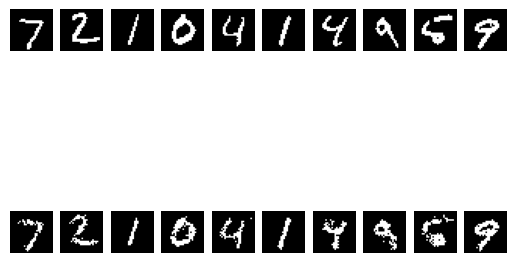

In [18]:
import matplotlib.pyplot as plt

# Visualize original and reconstructed images
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i].view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, i + 11)
    plt.imshow(v[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()